doing imports

In [15]:
import torch
import sys
import numpy as np 
import os
import yaml
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import math
from sklearn.metrics import confusion_matrix
device = 'cuda' if torch.cuda.is_available() else 'cpu'


c:\Users\no\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


creating the dataloader functions

In [2]:
def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.CIFAR10('.', train=True, download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.CIFAR10('.', train=False, download=download,
                                  transform=transforms.ToTensor())


  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

def get_cifar100_data_loaders(download, shuffle=False, batch_size=256):
  train_dataset = datasets.CIFAR100('.', train=True, download=download,
                                  transform=transforms.ToTensor())

  train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)
  
  test_dataset = datasets.CIFAR100('.', train=False, download=download,
                                  transform=transforms.ToTensor())


  test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
  return train_loader, test_loader

creating the model again

In [3]:
model = torchvision.models.resnet18(pretrained=False, num_classes=10).to(device)

loading the trained check point data

NOTE: please copy your preferred training check point tar from required subdirectory of run folder into root folder of this notebook. Also make sure that the below torch load function is pointing to the right tar file name

In [4]:

checkpoint = torch.load('checkpoint_0004.pth.tar', map_location=device)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()):

  if k.startswith('backbone.'):
    if k.startswith('backbone') and not k.startswith('backbone.fc'):
      # remove prefix
      state_dict[k[len("backbone."):]] = state_dict[k]
  del state_dict[k]

some necessary validations

In [5]:
log = model.load_state_dict(state_dict, strict=False)
assert log.missing_keys == ['fc.weight', 'fc.bias']

load the required datasets

In [6]:
cifar10_train_loader, cifar10_test_loader = get_cifar10_data_loaders(download=True)
_, cifar100_test_loader = get_cifar100_data_loaders(download=True)

Files already downloaded and verified
Files already downloaded and verified


c:\Users\no\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Files already downloaded and verified


select te final model parameters

In [7]:
# freeze all layers except the last
for name, param in model.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

parameters = list(filter(lambda p: p.requires_grad, model.parameters()))
assert len(parameters) == 2

create the optimizer and loss function

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)

create the accuracy function

In [9]:
def accuracy(output, target, topk=(1,)):
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

testing accuracy of CIFAR10 dataset with respect to CIFAR10 training

In [10]:
epochs = 10
top1_train_accuracy_list = [0]
top1_accuracy_list = [0]
top5_accuracy_list = [0]
epoch_list = [0]

for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(cifar10_train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(cifar10_test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
  
  top1_accuracy /= (counter + 1)
  top5_accuracy /= (counter + 1)

  top1_train_accuracy_list.append(top1_train_accuracy.item())
  top1_accuracy_list.append(top1_accuracy.item())
  top5_accuracy_list.append(top5_accuracy.item())
  epoch_list.append(epoch+1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

Epoch 0	Top1 Train accuracy 36.52463150024414	Top1 Test accuracy: 42.40808868408203	Top5 test acc: 90.35730743408203
Epoch 1	Top1 Train accuracy 43.53515625	Top1 Test accuracy: 44.20783615112305	Top5 test acc: 90.9886245727539
Epoch 2	Top1 Train accuracy 44.8090705871582	Top1 Test accuracy: 45.22116470336914	Top5 test acc: 91.20462036132812
Epoch 3	Top1 Train accuracy 45.638153076171875	Top1 Test accuracy: 45.925437927246094	Top5 test acc: 91.4183120727539
Epoch 4	Top1 Train accuracy 46.152740478515625	Top1 Test accuracy: 46.12936782836914	Top5 test acc: 91.689453125
Epoch 5	Top1 Train accuracy 46.575653076171875	Top1 Test accuracy: 46.54813766479492	Top5 test acc: 91.81755065917969
Epoch 6	Top1 Train accuracy 46.967872619628906	Top1 Test accuracy: 46.71300506591797	Top5 test acc: 91.91520690917969
Epoch 7	Top1 Train accuracy 47.19467544555664	Top1 Test accuracy: 46.848575592041016	Top5 test acc: 92.01171875
Epoch 8	Top1 Train accuracy 47.48365783691406	Top1 Test accuracy: 46.936466217

plot the result

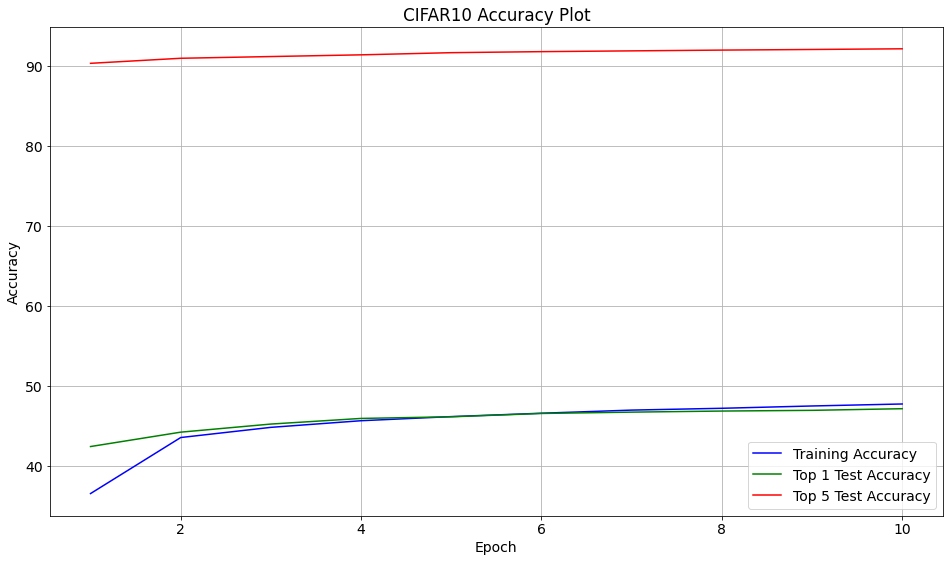

In [11]:
top1_train_accuracy_list.pop(0)
top1_accuracy_list.pop(0)
top5_accuracy_list.pop(0)
epoch_list.pop(0)

plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR10 Accuracy Plot')
plt.plot(epoch_list,top1_train_accuracy_list, c='b')
plt.plot(epoch_list,top1_accuracy_list, c='g')
plt.plot(epoch_list,top5_accuracy_list, c='r')
plt.legend(['Training Accuracy', 'Top 1 Test Accuracy', 'Top 5 Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show() 

testing accuracy of CIFAR100 dataset with respect to CIFAR10 training

In [12]:
epochs = 10
top1_train_accuracy_list = [0]
top1_accuracy_list = [0]
top5_accuracy_list = [0]
epoch_list = [0]

for epoch in range(epochs):
  top1_train_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(cifar10_train_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
    loss = criterion(logits, y_batch)
    top1 = accuracy(logits, y_batch, topk=(1,))
    top1_train_accuracy += top1[0]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  top1_train_accuracy /= (counter + 1)
  top1_accuracy = 0
  top5_accuracy = 0
  for counter, (x_batch, y_batch) in enumerate(cifar100_test_loader):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(x_batch)
  
    top1, top5 = accuracy(logits, y_batch, topk=(1,5))
    top1_accuracy += top1[0]
    top5_accuracy += top5[0]
  
  top1_accuracy /= (counter + 1)
  top5_accuracy /= (counter + 1)

  top1_train_accuracy_list.append(top1_train_accuracy.item())
  top1_accuracy_list.append(top1_accuracy.item())
  top5_accuracy_list.append(top5_accuracy.item())
  epoch_list.append(epoch+1)
  print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

Epoch 0	Top1 Train accuracy 47.890625	Top1 Test accuracy: 1.0426241159439087	Top5 test acc: 5.130399703979492
Epoch 1	Top1 Train accuracy 48.0365104675293	Top1 Test accuracy: 1.0133272409439087	Top5 test acc: 5.071805953979492
Epoch 2	Top1 Train accuracy 48.189971923828125	Top1 Test accuracy: 1.0035616159439087	Top5 test acc: 5.062040328979492
Epoch 3	Top1 Train accuracy 48.3111457824707	Top1 Test accuracy: 0.9742647409439087	Top5 test acc: 5.071805953979492
Epoch 4	Top1 Train accuracy 48.43869400024414	Top1 Test accuracy: 0.9644991159439087	Top5 test acc: 5.081571578979492
Epoch 5	Top1 Train accuracy 48.594146728515625	Top1 Test accuracy: 0.9742647409439087	Top5 test acc: 5.091337203979492
Epoch 6	Top1 Train accuracy 48.711734771728516	Top1 Test accuracy: 0.9937959909439087	Top5 test acc: 5.091337203979492
Epoch 7	Top1 Train accuracy 48.797035217285156	Top1 Test accuracy: 0.9937959909439087	Top5 test acc: 5.081571578979492
Epoch 8	Top1 Train accuracy 48.878746032714844	Top1 Test accur

plot the result

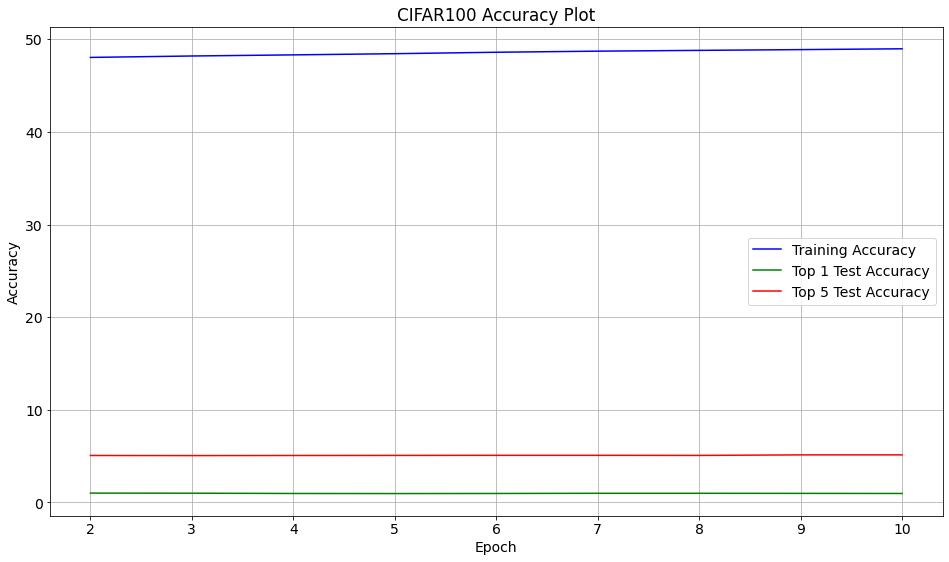

In [14]:
top1_train_accuracy_list.pop(0)
top1_accuracy_list.pop(0)
top5_accuracy_list.pop(0)
epoch_list.pop(0)

plt.figure(figsize = (16, 9))
plt.rcParams.update({'font.size': 14})
plt.title('CIFAR100 Accuracy Plot')
plt.plot(epoch_list,top1_train_accuracy_list, c='b')
plt.plot(epoch_list,top1_accuracy_list, c='g')
plt.plot(epoch_list,top5_accuracy_list, c='r')
plt.legend(['Training Accuracy', 'Top 1 Test Accuracy', 'Top 5 Test Accuracy'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show() 